In [ ]:
#!pip install pymorphy2
#!pip install fasttext
#!pip install transformers
#!pip install deeppavlov
!pip install top2vec[sentence_encoders]
#!pip install tensorflow tensorflow_hub tensorflow_text

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score, accuracy_score, f1_score, roc_auc_score, make_scorer, classification_report
import seaborn as sns
import umap
#from transformers import BertTokenizer, BertModel, AutoTokenizer
import torch
#from deeppavlov.models.preprocessors import bert_preprocessor
from scipy.sparse import hstack, vstack
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from mpl_toolkits.mplot3d import Axes3D
nltk.download('stopwords')
nltk.download("punkt")
from top2vec import Top2Vec
#import fasttext
#import fasttext.util
import re
import numpy as np
%matplotlib inline

In [6]:
df = pd.read_csv("news.csv")

In [7]:
df = df.replace('\n','', regex=True)

In [ ]:
fasttext.util.download_model('ru', if_exists='ignore')  
ft = fasttext.load_model('cc.ru.300.bin')

In [8]:
#df = df.dropna(subset=["title"])
#df = df.drop(columns=['rubric', 'subrubric', 'publication_date', 'source', 'tags'])
data = df['text'].values.tolist()

In [ ]:
lda_topics = ["politics.world", "coronavirus.world", "coronavirus.russia", "politics.russia", 'x1', 'x2', 'x3']

In [ ]:
patterns = r"[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
data = pd.DataFrame()

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    words = nltk.word_tokenize(doc)
    words = [morph.normal_forms(word)[0] for word in words]
    words = [word for word in words if not word in stopwords_ru]
    if len(words) > 2:        
        return " ".join(words)
    return None
  
data['title'] = df['title'].apply(lemmatize)
data['text'] = df['text'].apply(lemmatize)
#data['tags'] =  df['tags'].apply(lemmatize)
data.dropna(inplace=True)

In [ ]:
tfidf = TfidfVectorizer(max_features=3000, min_df=2, max_df=0.95)
tf_text = tfidf.fit_transform(data['text'])
tf_title = tfidf.transform(data['title'])
#tf_tags = tfidf.transform(data['tags'])

In [ ]:
tf_data = vstack([tf_text, tf_title])#, tf_tags])

In [ ]:
data['title'] = df['title'].apply(vectorize)
data['text'] = df['text'].apply(vectorize)
data['tags'] =  df['tags'].apply(vectorize)

In [ ]:
arr = np.array(data.values.tolist())
arr.shape
# nsamples, nx, ny = arr.shape
# arr = arr.reshape((nsamples, nx*ny))

In [ ]:
silh = {}
inertia = {}
for i in range(2, 15):
  kmeans = KMeans(i, random_state=42)
  kmeans.fit(tf_data)
  silh[i] = silhouette_score(tf_data, kmeans.labels_)
  inertia[i] = kmeans.inertia_
sns.barplot(x=list(silh.keys()), y=list(silh.values()))

In [ ]:
tsne = TSNE(2)
vis_data = tsne.fit_transform(tf_data)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


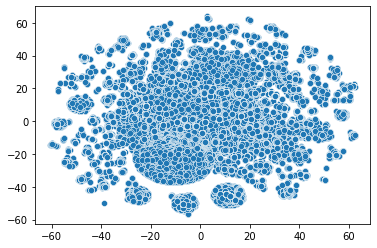

In [ ]:
sns.scatterplot(vis_data[:, 0], vis_data[:, 1])

In [ ]:
lda = LatentDirichletAllocation(n_components=7, random_state=42)
lda.fit(tf_data)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=7, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [ ]:
kmeans = KMeans(20, random_state=42)
clusters = kmeans.fit_predict(tf_data)

In [ ]:
results_df = get_model_topics(lda, tfidf, lda_topics)
topic, score, _ = get_inference(lda, tfidf, lda_topics, text, 0)
print(topic, score)

x1 [[0.01499766 0.01497003 0.44843929 0.02497718 0.46631817 0.01524279
  0.01505488]]


In [ ]:
def get_model_topics(model, vectorizer, topics, n_top_words=20):
    word_dict = {}
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        word_dict[topics[topic_idx]] = top_features

    return pd.DataFrame(word_dict)

In [ ]:
def get_inference(model, vectorizer, topics, text, threshold):

    text = re.sub(patterns, ' ', text)
    words = nltk.word_tokenize(text)
    words = [word for word in words if not word in stopwords_ru]
    words = [morph.normal_forms(word)[0] for word in words]
    text = " ".join(words)

    v_text = vectorizer.transform([text])
    score = model.transform(v_text)

    labels = set()
    for i in range(len(score[0])):
        if score[0][i] > threshold:
            labels.add(topics[i])

    if not labels:
        return 'None', -1, set()

    return topics[np.argmax(score)], score, labels

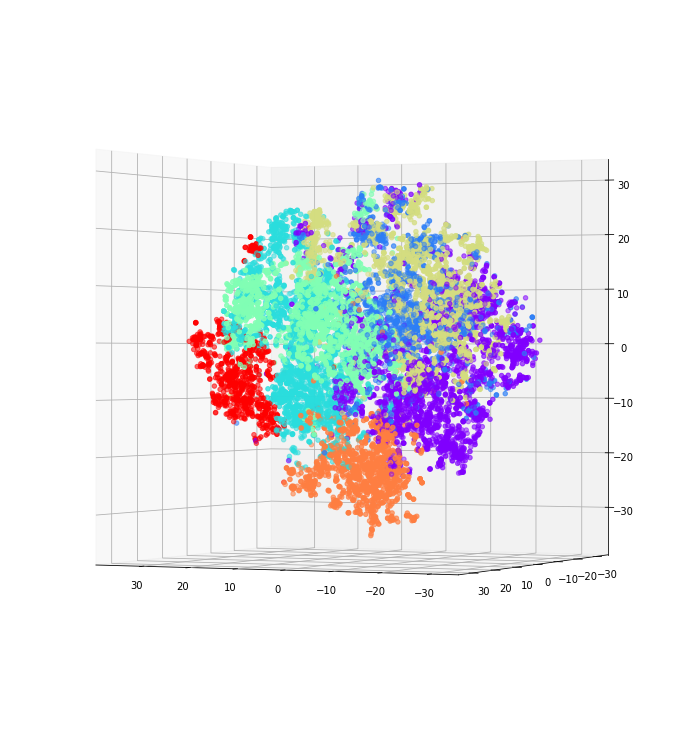

In [ ]:
#pca = TSNE(3)
#x_pca = pca.fit_transform(tf_data)
fig = plt.figure(1, figsize=(10,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=0, azim=115)
ax.scatter(x_pca[:, 0],x_pca[:, 1],x_pca[:, 2], c=clusters, cmap='rainbow')
#sns.scatterplot(x=x_pca[:, 0], y=x_pca[:, 1])

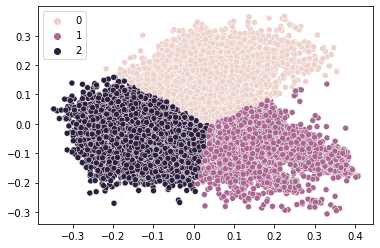

In [ ]:
prim_ca = PCA(2)
x_pca_2 = prim_ca.fit_transform(arr)
sns.scatterplot(x=x_pca_2[:, 0], y=x_pca_2[:, 1], hue=clusters)

In [ ]:
df = pd.read_csv("train.csv", index_col='ID')

patterns = r"[0-9!#$%&'()*+,.\/:;<=>?@[\]^_`{|}~—\"\-+\\]"
stopwords_ru = stopwords.words("english")
morph = MorphAnalyzer()

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    words = nltk.word_tokenize(doc)
    words = [morph.normal_forms(word)[0] for word in words]
    words = [word for word in words if not word in stopwords_ru]      
    return " ".join(words)

def vectorize(doc):
    doc = ft.get_sentence_vector(doc)
    return doc

x = df['TITLE'] + df['ABSTRACT']
x = x.apply(lemmatize)
x = x.apply(vectorize)
#tfidf = TfidfVectorizer(max_features=1000)
#X = tfidf.fit_transform(x)

train = df
target_labels = ["Computer Science" ,"Physics" , "Mathematics", "Statistics" , "Quantitative Biology" , "Quantitative Finance"]
train['label'] = train[target_labels].values.tolist()

le = LabelEncoder()
y = le.fit_transform(train['label'].astype(str))

In [ ]:
df = pd.read_csv("train.csv", index_col="ID")
data = df['TITLE'] + df['ABSTRACT']
data.head()

In [9]:
top2v = Top2Vec(data, embedding_model='universal-sentence-encoder-multilingual')

2021-03-01 17:00:15,425 - top2vec - INFO - Pre-processing documents for training
2021-03-01 17:00:41,002 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
2021-03-01 17:00:49,523 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-03-01 17:15:48,772 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-03-01 17:16:40,841 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-03-01 17:16:44,234 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [10]:
topic_num = top2v.get_num_topics()
topic_words, word_scores, topic_nums = top2v.get_topics(20)

UMAP(a=None, angular_rp_forest=True, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='cosine', metric_kwds=None,
     min_dist=0.1, n_components=2, n_epochs=None, n_jobs=-1, n_neighbors=15,
     negative_sample_rate=5, output_dens=False, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, ...)
Construct fuzzy simplicial set
Mon Mar  1 17:18:59 2021 Finding Nearest Neighbors
Mon Mar  1 17:18:59 2021 Building RP forest with 12 trees
Mon Mar  1 17:19:00 2021 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Mon Mar  1 17:19:03 2021 Finished Nearest Neighbor Search
Mon Ma

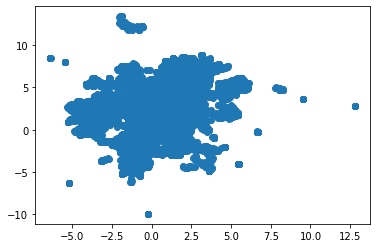

In [16]:
vectors = top2v._get_document_vectors()
reduced2d = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', verbose=True).fit_transform(vectors)
x, y = reduced2d[:,0], reduced2d[:,1]
plt.scatter(x,y)

In [12]:
test_ar = pd.DataFrame(topic_words)
test_ar

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,коронавирусную,коронавирусная,заболевших,коронавирусе,коронавируснои,коронавируса,коронавирус,коронавирусом,коронавирусу,вакцины,вакцинация,заболевшими,вакцинации,заболевшие,эпидемию,заразились,эпидемия,вакцина,пострадавших,вакцин,эпидемии,вакцину,заболеваемости,заразился,заболевшии,эпидемиеи,выздоровевших,стопкоронавирус,ранены,раненых,заболели,заболеваемость,гриппа,пострадавшие,пневмонию,инфицированных,пострадавшего,инфицирования,пневмонии,заболеваниями,болезнеи,заболеванию,пострадали,пневмония,больницах,погибших,заболевании,пострадавшим,ранения,больницы
1,арестованы,арестован,арестовали,обвиняемого,приговорили,обвиняемых,уголовнои,адвокаты,обвиняемыи,ареста,преступлениях,прокурор,преступников,обвиняли,адвокатов,уголовному,тюрьмы,аресте,арестом,арестовал,уголовное,арест,преступнои,прокуратуры,преступники,прокурора,обвинение,следственных,обвиняют,генпрокурора,обвинении,следственного,прокуратура,обвинению,подозреваемого,обвинения,преступления,адвоката,уголовного,обвинили,следственные,прокуратуру,преступлении,прокуратуре,осудили,приговорил,адвокат,генпрокуратура,приговора,обвиняется
2,коронавирусную,коронавирусом,коронавируса,коронавирусе,коронавирус,коронавирусная,коронавирусу,коронавируснои,вакцины,эпидемию,эпидемия,вакцинация,стопкоронавирус,вакцина,вакцинации,вакцин,эпидемии,вакцину,эпидемиеи,заболевших,вирусов,вирусолог,иммунитета,заразились,гриппа,иммунитет,инфицирования,вирусы,инфицированных,заболеваемости,заболевшими,вирусологии,заразился,заразиться,заболевшие,заболевшии,заболеваемость,пострадавших,вирусом,вирус,инфекционных,пандемию,вируснои,инфекционнои,пандемия,вируса,заболеваниями,выздоровевших,заболеванию,инфекции
3,коронавирусную,коронавирусе,коронавируса,коронавирусная,коронавирус,коронавирусом,коронавируснои,коронавирусу,эпидемия,эпидемию,эпидемии,заболевших,эпидемиеи,заразились,пострадавших,стопкоронавирус,минздраве,минздрава,минздрав,заболевшими,заразился,вакцинация,вакцинации,погибших,раненых,вакцины,ранены,вакцина,инфицирования,заболеваемости,инфицированных,заболевшие,вакцин,больницах,больного,гриппа,больницы,вакцину,пострадавшего,пострадавшие,пострадавшим,госпитализации,ранения,болезнеи,заболеваемость,смертность,пострадали,заразиться,выздоровевших,заболеванию
4,коронавируснои,коронавирусе,коронавирус,коронавирусную,коронавируса,коронавирусом,коронавирусная,коронавирусу,эпидемию,эпидемия,эпидемии,пандемию,эпидемиеи,пострадавших,пандемия,стопкоронавирус,здравоохранению,минздрав,медучреждения,заболеваемости,медицины,заболевших,минздраве,здравоохранение,минздрава,заболеваемость,пандемии,заболевшими,пострадавшим,медицинскои,пострадавшие,ранены,раненых,вакцинация,медицина,карантинвроссии,вакцины,вакцинации,инфицирования,болезнеи,больницы,заразились,выздоровевших,здравоохранения,заболеваниями,профилактики,республиканцев,министры,медицинскую,заразиться
5,режиссера,сериалов,актеры,режиссер,актеров,фильмах,боевиков,сериал,фильма,режиссером,фильме,фильм,боевики,сериале,фильмов,актера,фильмом,голливуде,комедии,драмы,фильмы,фильму,кино,сериала,актером,роли,эпизодов,боевиками,эпизоды,актер,актрисы,премьеры,актриса,эпизод,пленными,сюжет,кинологи,сюжета,плен,серию,кинотеатры,американскои,героиня,зрители,герои,сцену,премьера,снимал,зрителям,серии
6,животных,животными,животные,зоопарка,животное,обитания,животным,животного,кинологи,тигр,птицы,леопарда,птиц,собакои,диких,елизавета,воробьев,собак,арестованы,китаицев,собаки,медведь,медведя,титов,пострадавших,совбеза,численности,кошек,собака,население,сообщили,погибли,сообщается,заповедника,видов,сообщило,норвегии,новость,сообщает,пострадавшим,жителями,кошки,выведены,пострадавшие,норвегия,fox,илон,населением,находящихся,туристов
7,белорусов,белорусы,протестов,белорусскои,протесты,порошенко,протестах,протестующих,белоруссия,белоруссии,протестующие,белорусскии,белоруссиеи,белорусских,белорусские,беларуси,белоруссию,белорусского,выборах,лукаш